## **0. setting**

In [ ]:
# Import package
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install gensim

In [ ]:
import pandas as pd
import numpy as np

import gensim
from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTM, Dropout

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

PATH="/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Session4/Session4_Project/"
SEED=42

# Word2Vec 임베딩 벡터
embed=gensim.models.Word2Vec.load(PATH+'ko.bin')

In [ ]:
# drive.mount
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **1. Data Setting**

In [ ]:
# import data
df=pd.read_csv(PATH+'tripadvisor_hotel_reviews_check_trans_token.csv')
df=df[['Rating', 'Review_tokens']]

df.head(3)
print(df['Rating'].value_counts(normalize=True))

,Rating,Review_tokens
0,1,"['니스', '비싸다', '주차', '거래', '숙박', '기념일', '늦다', '..."
1,0,"['특별하다', '비용', '다이아몬드', '회원', '힐튼', '결정', '체인'..."
2,0,"['멋지다', '객실', '체험', '모나코', '시애틀', '레벨', '긍정', ..."


In [ ]:
# 데이터 분리
target='Rating'

train_val, test=train_test_split(df,
                              train_size=0.80,
                              test_size=0.20, 
                              stratify=df[target],
                              random_state=SEED)

train, val=train_test_split(train_val,
                            train_size=0.70,
                            test_size=0.30, 
                            stratify=train_val[target],
                            random_state=SEED)

X_train=train['Review_tokens']
X_val=val['Review_tokens']
X_test=test['Review_tokens']
y_train=train[target]
y_val=val[target]
y_test=test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((10291,), (10291,), (4411,), (4411,), (3676,), (3676,))

In [ ]:
# tokenizer에 텍스트 학습
tokenizer=Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train)

# vocab_size 확인
vocab_size=len(tokenizer.word_index)+1
print(f"토큰화 된 단어의 전체 갯수 {vocab_size}개")
print("-"*60)

# encoding 적용
X_train_encoded=tokenizer.texts_to_sequences(X_train)
X_val_encoded=tokenizer.texts_to_sequences(X_val)
X_test_encoded=tokenizer.texts_to_sequences(X_test)

# 문장 최대 길이 확인
max_len=max(len(sent) for sent in X_train_encoded)
print(f"encoded된 문장 중 가장 긴 문장의 길이 {max_len}")
print("-"*60)

# encoded 된 문장의 평균 길이
print(f'Mean length of train set: {np.mean([len(sent) for sent in X_train_encoded], dtype=int)}')
print("-"*60)

# pad_sequence 적용
# 길이가 같지 않을 경우, 이를 일정한 길이로 맞춤
X_train=pad_sequences(X_train_encoded, maxlen=max_len, padding='post')
X_val=pad_sequences(X_val_encoded, maxlen=max_len, padding='post')
X_test=pad_sequences(X_test_encoded, maxlen=max_len, padding='post')

# array로 형태 변환
y_train=np.array(y_train)
y_val=np.array(y_val)

# 0으로 채워진 embedding용 matrix 제작
embedding_matrix=np.zeros((vocab_size, max_len))
print(f"0으로 채워진 Embedding Matrix의 사이즈 {np.shape(embedding_matrix)}")

토큰화 된 단어의 전체 갯수는 15166개
------------------------------------------------------------
encoded된 문장 중 가장 긴 문장의 길이는 376
------------------------------------------------------------
Mean length of train set: 45
------------------------------------------------------------
0으로 채워진 Embedding Matrix의 사이즈 (15166, 376)


In [ ]:
# 해당 word가 word2vec에 있는 단어일 경우 임베딩 벡터를 반환
def get_vector(word):
    if word in embed:
        return embed[word]
    else:
        return None
 
for word, i in tokenizer.word_index.items():
    temp=get_vector(word)
    if temp is not None:
        embedding_matrix[i]=temp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  


## **2. Build Model & Training**

In [ ]:
# Seed
np.random.seed(2)
tf.random.set_seed(2)

# 변수
embedding_size=32
vocab_size=17012
max_len=394

# 모델 세팅
model=Sequential()
model.add(Embedding(vocab_size,
                    embedding_size,
                    weights=[embedding_matrix],
                    input_length = max_len))
model.add(LSTM(256,
               return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(256,
                activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,
                activation='relu'))
model.add(Dense(1,
                activation='sigmoid'))

# complie
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 결과 확인
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 394, 32)           544384    
_________________________________________________________________
lstm (LSTM)                  (None, 394, 256)          295936    
_________________________________________________________________
dropout (Dropout)            (None, 394, 256)          0         
_________________________________________________________________
dense (Dense)                (None, 394, 256)          65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 394, 256)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 394, 128)          32896     
_________________________________________________________________
dense_2 (Dense)              (None, 394, 1)            1

In [ ]:
# model train
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64)

Epoch 1/5
230/230 [==============================] - 270s 1s/step - loss: 0.5667 - accuracy: 0.7502 - val_loss: 0.4370 - val_accuracy: 0.8009
Epoch 2/5
230/230 [==============================] - 265s 1s/step - loss: 0.4496 - accuracy: 0.8224 - val_loss: 0.4418 - val_accuracy: 0.7903
Epoch 3/5
230/230 [==============================] - 265s 1s/step - loss: 0.4331 - accuracy: 0.8168 - val_loss: 0.4998 - val_accuracy: 0.8093
Epoch 4/5
230/230 [==============================] - 264s 1s/step - loss: 0.4827 - accuracy: 0.8119 - val_loss: 0.4740 - val_accuracy: 0.8129
Epoch 5/5
230/230 [==============================] - 260s 1s/step - loss: 0.4685 - accuracy: 0.7892 - val_loss: 0.4559 - val_accuracy: 0.8121


## **3. Model Tuning**

In [ ]:
# 1차 
# 변수 지정
embedding_size = 32

# Seed
np.random.seed(2)
tf.random.set_seed(2)

def model_build():
  model_2 = Sequential(
      [
        Embedding(vocab_size,
                  embedding_size,
                  input_length = max_len),
        LSTM(256,
             return_sequences=True),
        Dropout(0.2),
        Dense(256, 
              activation='relu',
              kernel_regularizer=regularizers.l1(0.00001)),
        Dropout(0.2),
        Dense(128, 
              activation='relu'),
        Dense(1, 
              activation='sigmoid')
      ]
  )
  model_2.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

  return model_2

# 모델 생성
model_2 = KerasClassifier(build_fn=model_build, verbose=0)

# param_grid 설정
batch_size = [64, 128]
epochs = [5, 7]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# GridSearch
grid = GridSearchCV(estimator=model_2, param_grid=param_grid, n_jobs=-1, cv=2)
grid_result = grid.fit(X_train, y_train)

In [ ]:
# best_params 선정 (epochs, batch_size)가 나옴
print(f'best_score:{grid_result.best_score_}')

In [ ]:
# best score 확인
rs = pd.DataFrame(grid_result.cv_results_).sort_values(by='rank_test_score').head()
rs.T

**결과 확인** (노트북을 나누어 돌려서 1차 튜닝 결과는 이미지로 업로드 하였습니다)
- batch_size = 64, epochs = 5 확인

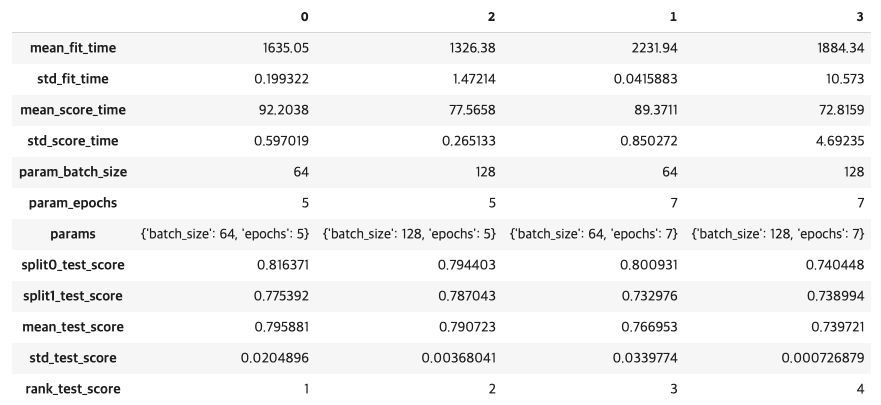

In [ ]:
# 2차 
# 변수 지정
embedding_size = 32

# Seed
np.random.seed(2)
tf.random.set_seed(2)

def model_build_2(drop_1=0.2):
  model_3 = Sequential(
      [
        Embedding(vocab_size,
                  embedding_size,
                  input_length = max_len),
        LSTM(256,
             return_sequences=True),
        Dropout(drop_1),
        Dense(256, 
              activation='relu',
              kernel_regularizer=regularizers.l1(0.00001)),
        Dropout(0.2),
        Dense(128, 
              activation='relu'),
        Dense(1, 
              activation='sigmoid')
      ]
  )
  model_3.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

  return model_3

# 모델 생성
model_3 = KerasClassifier(build_fn = model_build_2, epochs = 5, batch_size = 64, verbose=0)

# param_grid 설정
param_grid_2 = {'drop_1' : [0.2, 0.4]}

# GridSearch
grid_2 = GridSearchCV(estimator=model_3, param_grid=param_grid_2, n_jobs=-1, cv=2)
grid_result_2 = grid_2.fit(X_train, y_train)

In [ ]:
# best_params 선정
print(f'best_score:{grid_result_2.best_score_}')

best_score:0.8111699223518372


In [ ]:
# best score 확인
rs=pd.DataFrame(grid_result_2.cv_results_).sort_values(by='rank_test_score').head()
rs.T

,1,0
mean_fit_time,2452.63,2448.62
std_fit_time,5.3502,1.63641
mean_score_time,122.475,124.772
std_score_time,2.25402,0.0213926
param_drop_1,0.4,0.2
params,{'drop_1': 0.4},{'drop_1': 0.2}
split0_test_score,0.803626,0.799033
split1_test_score,0.818713,0.813986
mean_test_score,0.81117,0.806509
std_test_score,0.00754356,0.00747639
